In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/qrot/notebooks`


In [2]:
using OptimalTransport
using Plots
using LinearAlgebra
using Random
using Distributions
using Distances
using Graphs
using SimpleWeightedGraphs
using GraphRecipes
using NearestNeighbors
using SparseArrays
using ManifoldLearning
using NNlib
using ForwardDiff
using QuadGK
using Roots
using MultivariateStats
using LaTeXStrings

In [3]:
include("../src/util.jl")
Random.seed!(42)

TaskLocalRNG()

In [4]:
### Generate spiral data
m = 100
N = 1_000
f(t) = [cos(t)*(0.5cos(6t)+1) sin(t)*(0.4cos(6t)+1) 0.4sin(6t)]
arclength(t::Real) = quadgk(t -> norm(ForwardDiff.derivative(f, t)), 0, t, rtol = 1e-8)[1]
L_tot = arclength(2π)
t_range_scaled = range(0, 1; length = N+1)[1:end-1]
θ_range = map(x -> find_zero(t -> arclength(t)/L_tot - x, (0., 2π)), t_range_scaled)
R = qr(randn(m, m)).Q[:, 1:3]
X = vcat(f.(θ_range)...)' 
ρ(θ) = 0.05 + 1.25*(1 + cos(6θ))/2
η = hcat([x/norm(x)*ρ(θ) for (θ, x) in zip(θ_range, eachcol(randn(m, size(X, 2))))]...);
X_embed = R * X + η;
X_embed_orig = R * X;

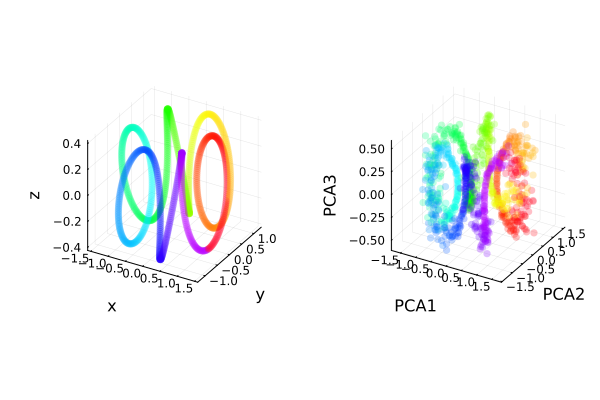

In [5]:
pca = fit(PCA, X_embed; maxoutdim = 25)
X_pca = MultivariateStats.transform(pca, X_embed)
plt1=Plots.scatter(collect(eachcol(vcat(f.(θ_range)...)))...; 
        xlabel = "x", ylabel = "y", zlabel = "z", 
        marker_z = θ_range, color = :gist_rainbow, markerstrokewidth = 0, colorbar = nothing, legend = nothing, alpha = 0.25)
plt2=Plots.scatter(collect(eachrow(X_pca[1:3, :]))...; 
        xlabel = "PCA1", ylabel = "PCA2", zlabel = "PCA3", 
        marker_z = θ_range, color = :gist_rainbow, markerstrokewidth = 0, colorbar = nothing, legend = nothing, alpha = 0.25)
plt=plot(plt1, plt2)
savefig("../figures/spiral_clean_noisy.svg")
plt

In [6]:
arclength(X) = cumsum([norm(x-y) for (x, y) in zip(eachcol(X[:, 1:end-1]), eachcol(X[:, 2:end]))]);
l = [quadgk(t -> norm(ForwardDiff.derivative(f, t)), 0, tfinal, rtol = 1e-8)[1] for tfinal in θ_range]
extrema(l[2:end].-l[1:end-1]) # check we are sampling w.r.t. arclength

(0.017358703133528053, 0.01735870313353871)

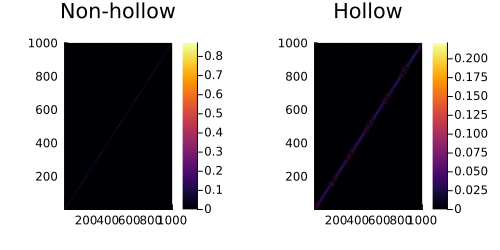

In [7]:
### Test with hollow projection (or not)
ε = 1.0
W = kernel_ot_quad(X_embed, ε, diag_inf = false); # non-hollow projection
W_ = kernel_ot_quad(X_embed, ε, diag_inf = true);  # hollow projection
plot(heatmap(W; title = "Non-hollow"), heatmap(W_; title = "Hollow"), size = (500, 250), margin = 5Plots.mm)

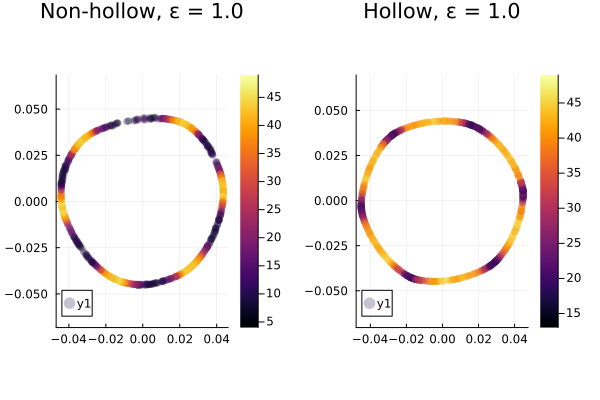

In [8]:
W_decomp = real.(eigen(W).vectors)
W__decomp = real.(eigen(W_).vectors)
plot(scatter(W_decomp[:, end-1], W_decomp[:, end-2]; marker_z = vec(sum(W .> 0; dims = 2)), alpha = 0.25, markerstrokewidth = 0, colorbar = true, title = "Non-hollow, ε = $(ε)", aspectratio = :equal), 
    scatter(W__decomp[:, end-1], W__decomp[:, end-2]; marker_z = vec(sum(W_ .> 0; dims = 2)), alpha = 0.25, markerstrokewidth = 0, colorbar = true, title = "Hollow, ε = $(ε)", aspectratio = :equal))

In [9]:
### Parameter sweep for kernel constructions

using PyCall
# kNN parameter sweep
k_vals = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50] 

# MAGIC
magic = pyimport("magic")
magic_op_all = [magic.MAGIC() for _ in k_vals]
[op.set_params(t = 5, knn = k) for (k, op) in zip(k_vals, magic_op_all)]
X_embed_magic_all = [op.fit_transform(X_embed', genes = "all_genes")' for op in magic_op_all]

# ε values
N = size(X_embed, 2)
ε_all_quad = 10f0.^range(-2.0, 2.0; length = 50)
ε_all_epanech = (ε_all_quad) .^ (2 / (2 + 1)) 
ε_all = 10f0.^range(-2.0, 2.0; length = 50)

W_all = Dict(k => (x, [f(X_embed, ε) for ε in x]) for (k, f, x) in zip(["quad", "ent", "epanech", ["knn_$k" for k in k_vals]..., "sym", "gauss_l2"],
                                                                       [kernel_ot_quad, kernel_ot_ent, kernel_epanech,
                                                                       [(x, ε) -> norm_kernel(form_kernel(x, ε; k = k), :sym) for k in k_vals]...,
                                                                        (x, ε) -> norm_kernel(form_kernel(x, ε; k = Inf), :sym), 
                                                                        kernel_gaussian_l2_proj],
                                                                       [ε_all_quad, ε_all, ε_all_epanech, [ε_all for _ in k_vals]..., ε_all, ε_all]));

Calculating MAGIC...
  Running MAGIC on 1000 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating imputation...
Calculated MAGIC in 0.18 seconds.
Calculating MAGIC...
  Running MAGIC on 1000 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating imputation...
Calculated MAGIC in 0.19 seconds.
Calculating MAGIC...
  Running MAGIC on 1000 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities i

In [12]:
function rw_norm_eigvecs(W)
    # Compute row-normalized eigenvectors for W
    D = Diagonal(vec(sum(W; dims = 2)))
    D^(-1/2) * eigen(Hermitian(W)).vectors
end
W_all_decomp = Dict(k => [rw_norm_eigvecs(y) for y in x] for (k, (_, x)) in W_all);

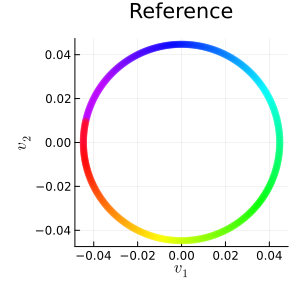

In [13]:
# Compute reference eigenvector embedding
W_ref = norm_kernel(form_kernel(X, 0.05; k = 3), :sym)
W_ref_decomp = rw_norm_eigvecs(W_ref);

plt=scatter(collect(eachcol(W_ref_decomp[:, end-2:end-1]))...; 
    aspect_ratio = :equal, title = "Reference", alpha = 0.25, 
    markersize = 4, marker_z = θ_range, color = :gist_rainbow, legend = nothing, markerstrokewidth = 0,
    size = (300, 300), xlabel = L"v_1", ylabel = L"v_2")
savefig("../figures/spiral_ref.svg")
plt

In [14]:
# Uncomment to plot eigenvector embeddings for each parameter sweep
# Plots.plot([scatter(collect(eachcol(x[:, end-2:end-1]))...; alpha = 0.1) for x in W_all_decomp["quad"]]...; axis = nothing, legend = nothing, markersize = 1, ylim = (-0.1, 0.1), xlim = (-0.1, 0.1), plot_title = "Quadratic", size = (500, 500))
# Plots.plot([scatter(collect(eachcol(x[:, end-2:end-1]))...; alpha = 0.1) for x in W_all_decomp["epanech"]]...; axis = nothing, legend = nothing, markersize = 1, ylim = (-0.1, 0.1), xlim = (-0.1, 0.1), plot_title = "Epanech", size = (500, 500))
# Plots.plot([scatter(collect(eachcol(x[:, end-2:end-1]))...; alpha = 0.1) for x in W_all_decomp["ent"]]...; axis = nothing, legend = nothing, markersize = 1, ylim = (-0.1, 0.1), xlim = (-0.1, 0.1), plot_title = "Entropic", size = (500, 500))
# Plots.plot([scatter(collect(eachcol(x[:, end-2:end-1]))...; alpha = 0.1) for x in W_all_decomp["knn_10"]]...; axis = nothing, legend = nothing, markersize = 1, ylim = (-0.1, 0.1), xlim = (-0.1, 0.1), plot_title = "kNN + Gaussian", size = (500, 500))
# Plots.plot([scatter(collect(eachcol(x[:, end-2:end-1]))...; alpha = 0.1) for x in W_all_decomp["sym"]]...; axis = nothing, legend = nothing, markersize = 1, ylim = (-0.1, 0.1), xlim = (-0.1, 0.1), plot_title = "Gaussian", size = (500, 500))

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


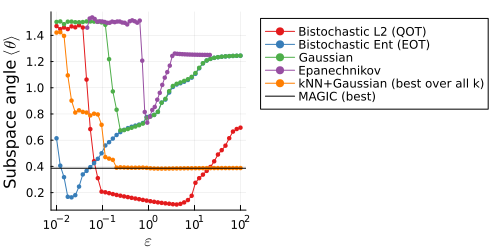

In [16]:
# Compute subspace angles
scipy = pyimport("scipy")
function geterr(x::AbstractMatrix, y::AbstractMatrix)
    return mean(scipy.linalg.subspace_angles(x, y))
end
err_all = Dict(k => map(W -> geterr(W_ref_decomp[:, end-10:end-1], W[:, end-10:end-1]), x) for (k, x) in W_all_decomp)
err_magic = Dict(k => geterr(W_ref_decomp[:, end-10:end-1], real.(eigen(op.diff_op.todense()).vectors[:, end-10:end-1])) for (k, op) in zip(k_vals, magic_op_all));

plt=Plots.plot(W_all["quad"][1], err_all["quad"], xscale = :log10, label = "Bistochastic L2 (QOT)", 
        palette = :Set1_9, legend = :outertopright, xlabel = L"ε", ylabel = string("Subspace angle ", L"⟨θ⟩"), m = "o", markerstrokewidth = 0, size = (500, 250), markersize = 2.5)
Plots.plot!(W_all["ent"][1], err_all["ent"]; label = "Bistochastic Ent (EOT)", m = "o", markerstrokewidth = 0, markersize = 2.5)
Plots.plot!(W_all["sym"][1], err_all["sym"]; label = "Gaussian", m = "o", markerstrokewidth = 0, markersize = 2.5)
Plots.plot!(W_all["epanech"][1], err_all["epanech"]; label = "Epanechnikov", m = "o", markerstrokewidth = 0, markersize = 2.5)
Plots.plot!(W_all["knn_10"][1], minimum(hcat([err_all["knn_$k"] for k in k_vals]...); dims = 2); label = "kNN+Gaussian (best over all k)", m = "o", markerstrokewidth = 0, markersize = 2.5)
hline!([last(minimum(values(err_magic))), ]; label = "MAGIC (best)", color = :black)
Plots.savefig("../figures/spiral_subspace_angle.svg")
plt

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


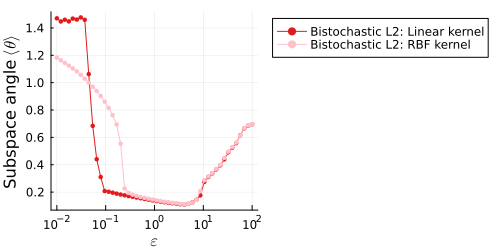

In [17]:
plt=Plots.plot(W_all["quad"][1], err_all["quad"], xscale = :log10, label = "Bistochastic L2: Linear kernel", 
        palette = :Set1_9, legend = :outertopright, xlabel = L"ε", ylabel = string("Subspace angle ", L"⟨θ⟩"), m = "o", markerstrokewidth = 0, size = (500, 250), markersize = 2.5)
Plots.plot!(W_all["gauss_l2"][1], err_all["gauss_l2"]; label = "Bistochastic L2: RBF kernel", m = "o", markerstrokewidth = 0, markersize = 2.5, c = :pink)
Plots.savefig("../figures/spiral_linear_rbf_comparison.pdf")
plt

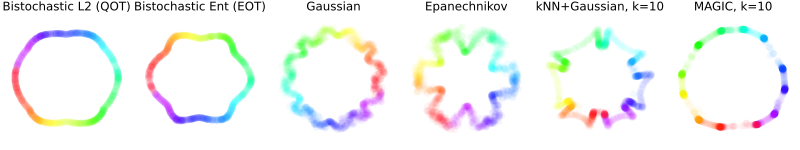

In [18]:
k=10
plt=Plots.plot(Plots.scatter(collect(eachcol(W_all_decomp["quad"][argmin(err_all["quad"])][:, end-2:end-1]))...; alpha = 0.05, title = "Bistochastic L2 (QOT)", marker_z = θ_range, color = :gist_rainbow, aspectratio = :equal, markerstrokewidth = 0),
     Plots.scatter(collect(eachcol(W_all_decomp["ent"][argmin(err_all["ent"])][:, end-2:end-1]))...; alpha = 0.05, title = "Bistochastic Ent (EOT)", marker_z = θ_range, color = :gist_rainbow, aspectratio = :equal, markerstrokewidth = 0), 
     Plots.scatter(collect(eachcol(W_all_decomp["sym"][argmin(err_all["sym"])][:, end-2:end-1]))...; alpha = 0.05, title = "Gaussian", marker_z = θ_range, color = :gist_rainbow, aspectratio = :equal, markerstrokewidth = 0),
     Plots.scatter(collect(eachcol(W_all_decomp["epanech"][argmin(err_all["epanech"])][:, end-2:end-1]))...; alpha = 0.05, title = "Epanechnikov", marker_z = θ_range, color = :gist_rainbow, aspectratio = :equal, markerstrokewidth = 0), 
     Plots.scatter(collect(eachcol(W_all_decomp["knn_$k"][argmin(err_all["knn_$k"])][:, end-2:end-1]))...; alpha = 0.05, title = "kNN+Gaussian, k=$k", marker_z = θ_range, color = :gist_rainbow, aspectratio = :equal, markerstrokewidth = 0), 
     Plots.scatter(collect(eachcol(real.(eigen(magic_op_all[k_vals .== k][1].diff_op.todense()).vectors[:, end-2:end-1])))...; alpha = 0.05, title = "MAGIC, k=$k", marker_z = θ_range, color = :gist_rainbow, aspectratio = :equal, markerstrokewidth = 0),
           ; legend = nothing, markersize = 4, markerstrokewidth = 0, colorbar = nothing, color = :viridis, xaxis = nothing, yaxis = nothing, layout = (1, 6), size = (800, 150), titlefontsize = 8, border = :none)
Plots.savefig("../figures/spiral_best.svg")
plt

In [19]:
# Geodesic approximation
W_quad = W_all["quad"][2][argmin(err_all["quad"])]
W_ent = W_all["ent"][2][argmin(err_all["ent"])]

function varadhan_cost(W, t=5.0)
    L_op = I - W
    -log.(exp(-t*L_op))
end
C_quad = varadhan_cost(W_quad)
C_ent = varadhan_cost(W_ent)

using Printf 
f(x, t, σ) = exp(-(x-t)^2 / σ^2)
μ = normalize(f.(t_range_scaled, 0.25, 0.05), 1)
ν = normalize(f.(t_range_scaled, 0.75, 0.05), 1)
plts_ent = []
plts_quad = []
eps = 1.0 # since no prefactor in varadhan
for s in range(0, 1; length = 5)
    μ_interp = sinkhorn_barycenter(hcat(μ, ν), C_ent, eps, [s, 1-s], SinkhornGibbs())
    push!(plts_ent, scatter(X_pca[1, :], X_pca[2, :], X_pca[3, :]; 
                        marker_z = μ_interp, msw = 0, colorbar = nothing, 
                        legend = nothing, clim = (0, quantile(μ_interp, 0.975)), 
                        xaxis = nothing, yaxis = nothing, zaxis = nothing, border = :none, 
                        aspectratio = :equal, markersize = 2.5, alpha = 0.25, c = :magma
                       ))
    μ_interp = sinkhorn_barycenter(hcat(μ, ν), C_quad, eps, [s, 1-s], SinkhornGibbs())
    push!(plts_quad, scatter(X_pca[1, :], X_pca[2, :], X_pca[3, :]; 
                        marker_z = μ_interp, msw = 0, colorbar = nothing, 
                        legend = nothing, clim = (0, quantile(μ_interp, 0.975)), 
                        xaxis = nothing, yaxis = nothing, zaxis = nothing, border = :none, 
                        aspectratio = :equal, markersize = 2.5, alpha = 0.25, c = :magma
                       ))
end

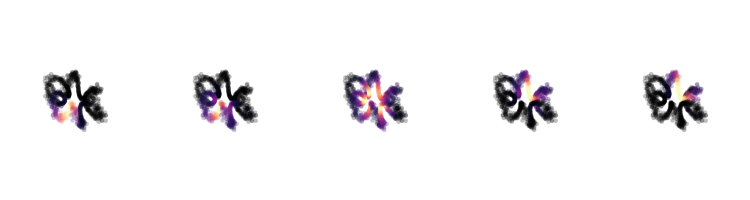

In [20]:
plt=plot(plts_ent...; layout = (1, 5), size = (750, 200), cam = (30, 70))
savefig("../figures/geodesic_ent.svg")
plt

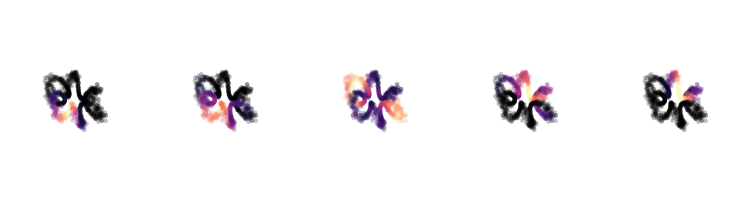

In [21]:
plt=plot(plts_quad...; layout = (1, 5), size = (750, 200), cam = (30, 70))
savefig("../figures/geodesic_quad.svg")
plt

In [22]:
plts_quad = []
plts_ent = []
plts_knn = []
for d in [3, 5, 10, 25, 100]
    pca_op = fit(PCA, X_embed; maxoutdim = d)
    X_pca = pca_op.proj' * X_embed;
    W_quad = kernel_ot_quad(X_pca, ε_all_quad[argmin(err_all["quad"])])
    # W_quad = kernel_ot_quad(X_pca, 1.0)
    W_quad_decomp = rw_norm_eigvecs(W_quad);
    push!(plts_quad, scatter(collect(eachcol(W_quad_decomp[:, end-2:end-1]))...; alpha = 0.5, markerstrokewidth = 0, marker_z = θ_range, color = :gist_rainbow, title = "d = $d"))
    W_ent = kernel_ot_ent(X_pca, ε_all[argmin(err_all["ent"])])
    # W_ent = kernel_ot_ent(X_pca, 0.025)
    W_ent_decomp = rw_norm_eigvecs(W_ent);
    push!(plts_ent, scatter(collect(eachcol(W_ent_decomp[:, end-2:end-1]))...; alpha = 0.5, markerstrokewidth = 0, marker_z = θ_range, color = :gist_rainbow, title = "d = $d"))
    W_knn = Array(norm_kernel(form_kernel(X_pca, 1.0; k = 25), :sym))
    W_knn_decomp = rw_norm_eigvecs(W_knn);
    push!(plts_knn, scatter(collect(eachcol(W_knn_decomp[:, end-2:end-1]))...; alpha = 0.5, markerstrokewidth = 0, marker_z = θ_range, color = :gist_rainbow, title = "d = $d"))
end

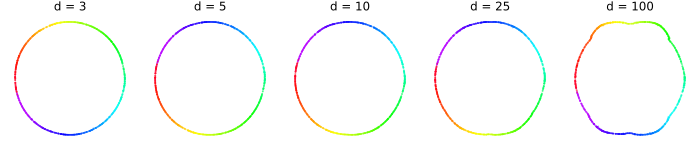

In [23]:
plt=plot(plts_quad...; layout = (1, 5), legend = nothing, markersize = 1, markerstrokewidth = 0, colorbar = nothing, xaxis = nothing, yaxis = nothing, size = (700, 150), titlefontsize = 8, border = :none, alpha = 1)
savefig("../figures/spiral_dim_pca_quad.svg")
plt

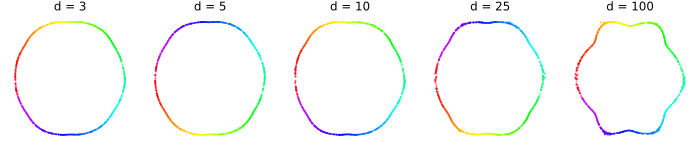

In [24]:
plt=plot(plts_ent...; layout = (1, 5), legend = nothing, markersize = 1, markerstrokewidth = 0, colorbar = nothing, xaxis = nothing, yaxis = nothing, size = (700, 150), titlefontsize = 8, border = :none, alpha = 1)
savefig("../figures/spiral_dim_pca_ent.svg")
plt

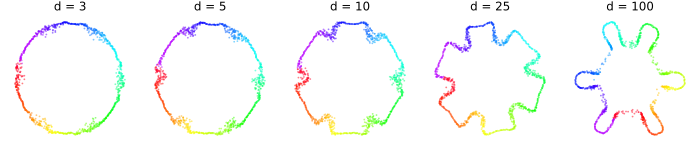

In [25]:
plt=plot(plts_knn...; layout = (1, 5), legend = nothing, markersize = 1, markerstrokewidth = 0, colorbar = nothing, xaxis = nothing, yaxis = nothing, size = (700, 150), titlefontsize = 8, border = :none, alpha = 1)
savefig("../figures/spiral_dim_pca_knn.svg")
plt